<a href="https://colab.research.google.com/github/w1947567/Demand-forecasting/blob/main/LSTM_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [86]:
# Read the Excel file
data = pd.read_excel('/content/1161000_until2023.xlsx', engine='openpyxl')


In [88]:
#Drop first two columns
data=data.drop(['Product', 'Year ID'], axis=1)
data.head(10)

,Year,Month,Volume
0,2010,1,982341
1,2010,2,826768
2,2010,3,992751
3,2010,4,862735
4,2010,5,891303
5,2010,6,902686
6,2010,7,928333
7,2010,8,699951
8,2010,9,784516
9,2010,10,887350


In [89]:
#Combine 'Year' and 'Month'
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
data = data.drop(['Year', 'Month'], axis=1)
data.head(5)

,Volume,Date
0,982341,2010-01-01
1,826768,2010-02-01
2,992751,2010-03-01
3,862735,2010-04-01
4,891303,2010-05-01


In [90]:
#Swap columns
data=data[['Date', 'Volume']]
data.head(5)

,Date,Volume
0,2010-01-01,982341
1,2010-02-01,826768
2,2010-03-01,992751
3,2010-04-01,862735
4,2010-05-01,891303


In [49]:
#Identify null value
data.isna().sum()

,0
Date,0
Volume,0


<Axes: >

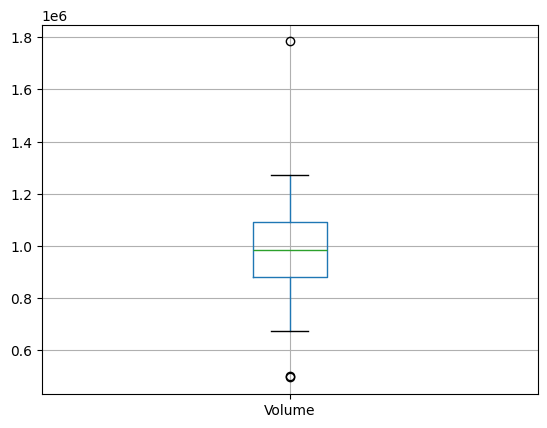

In [91]:
#Outliers identification
data.boxplot('Volume')

In [92]:
#Identification and count of outliers
def find_outliers_IQR(data, column):
  Q1=data[column].quantile(0.25)
  Q3=data[column].quantile(0.75)
  IQR=Q3-Q1

  lower_bound=Q1-1.5*IQR
  upper_bound=Q3+1.5*IQR

  outliers_below=data[data[column]<lower_bound].shape[0]
  outliers_above=data[data[column]>upper_bound].shape[0]
  total_outliers=outliers_above+outliers_below

  return total_outliers

volume=find_outliers_IQR(data, 'Volume')
print('Number of outliers in Volume:', volume)
print('Percentage of outliers in Volume:', round(volume/len(data)*100, 2), '%')

Number of outliers in Volume: 3
Percentage of outliers in Volume: 1.79 %


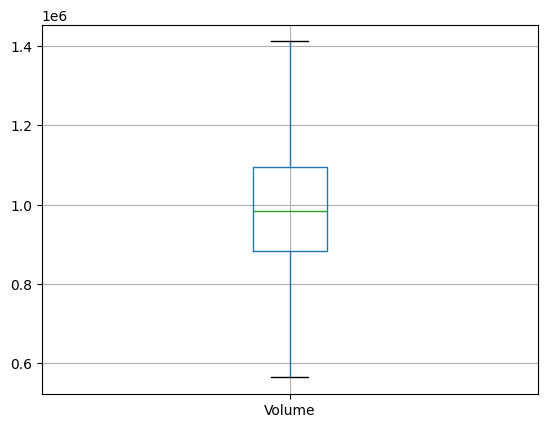

In [52]:
#Replace outliers
def replace_outliers(data, column):
    data = data.copy()
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data[column] = data[column].apply(
        lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x
    )
    return data

data1=replace_outliers(data, 'Volume')
data1.boxplot('Volume')
#Adding back the 'Date' column to data1
data1['Date'] = data['Date'] # Add this line to include the 'Date' column in data1

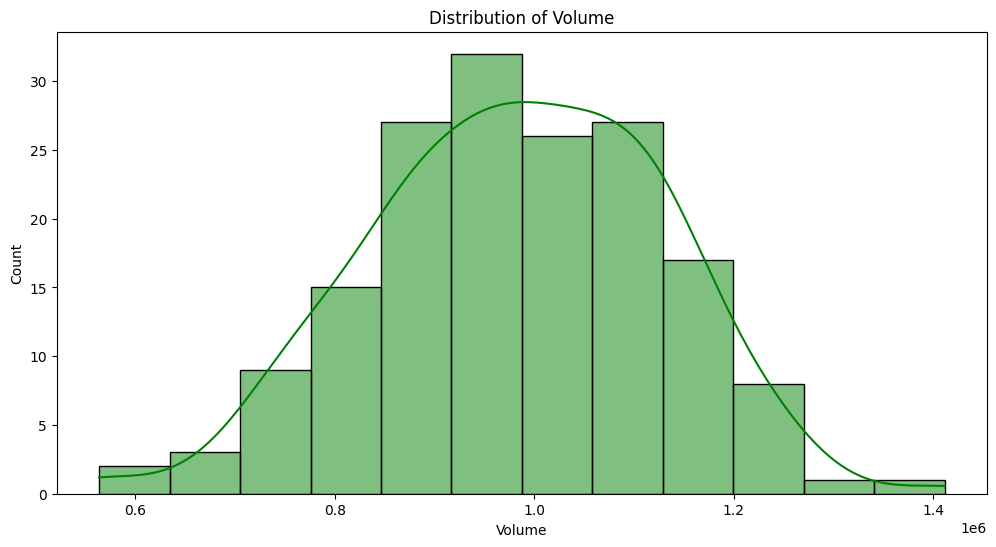

In [53]:
#Distribution
import seaborn as sns
plt.figure(figsize=(12,6))
sns.histplot(data1['Volume'], kde=True, color='green')
plt.title('Distribution of Volume')
plt.show()

<Axes: >

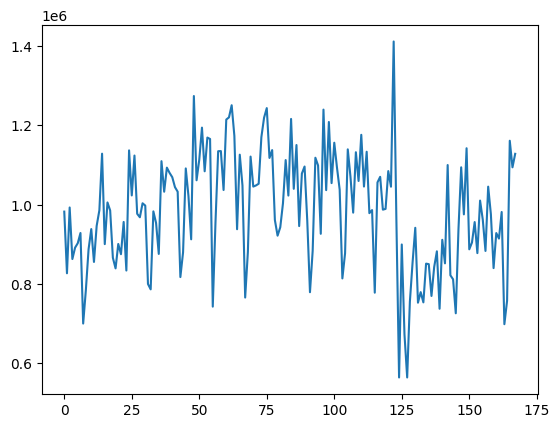

In [54]:
#Plot Volume
volume=data1['Volume']
volume.plot()

In [55]:
data1.head(5)

,Date,Volume
0,2010-01-01,"982,341.00"
1,2010-02-01,"826,768.00"
2,2010-03-01,"992,751.00"
3,2010-04-01,"862,735.00"
4,2010-05-01,"891,303.00"


In [56]:
data1=data.drop(['Date'], axis=1)
data1.head(5)

,Volume
0,982341
1,826768
2,992751
3,862735
4,891303


In [57]:
#Fix random seed for reproducibility
np.random.seed(7)

In [58]:
# Convert integer values to floating point values (Convert to NumPy array and ensure numeric data)
try:
    data2 = data1.values
    data2 = data2.astype('float32')
except ValueError:
    raise ValueError("Ensure that all columns in data1 are numeric.")

In [59]:
#Normalise the data
scaler=MinMaxScaler(feature_range=(0,1))
data2=scaler.fit_transform(data2)

In [60]:
# Reshape for Neural Network input
try:
    print("Shape before reshaping:", data2.shape)
    data2 = data2.reshape((data2.shape[0], 1, data2.shape[1]))
    print("Shape after reshaping:", data2.shape)
except ValueError as e:
    raise ValueError(f"Reshape failed: {e}")

print("Length of data2:", len(data2))

Shape before reshaping: (168, 1)
Shape after reshaping: (168, 1, 1)
Length of data2: 168


In [61]:
#Split data into training & testing sets
train_set = int(len(data2) * 0.80)
test_set = len(data2) - train_set
train, test = data2[0:train_set, :], data2[train_set:len(data2), :]
print(len(train), len(test))

134 34


In [62]:
print(train.shape)
print(test.shape)

(134, 1, 1)
(34, 1, 1)


In [63]:
# Convert an array of values into a dataset matrix
def new_dataset(data2, look_back=1):
    dataX, dataY = [], []
    print(f"Input data shape: {data2.shape}")

    # Loop to create dataset
    for i in range(len(data2) - look_back - 1):
        a = data2[i:(i + look_back), 0]  # Extract a sequence of 'look_back' timesteps
        dataX.append(a)
        dataY.append(data2[i + look_back, 0])  # Target is the next timestep

    # Convert lists to numpy arrays
    dataX, dataY = np.array(dataX), np.array(dataY)

    # Print shapes and samples
    print(f"Output dataX shape: {dataX.shape}, Output dataY shape: {dataY.shape}")
    print("Sample dataX[0]:", dataX[0] if len(dataX) > 0 else "Empty")
    print("Sample dataY[0]:", dataY[0] if len(dataY) > 0 else "Empty")

    return dataX, dataY

# Example usage and debugging
look_back = 2
dataX, dataY = new_dataset(data2, look_back=look_back)

# Validate the results
print("First few sequences in dataX:", dataX[:5])
print("First few targets in dataY:", dataY[:5])

Input data shape: (168, 1, 1)
Output dataX shape: (165, 2, 1), Output dataY shape: (165, 1)
Sample dataX[0]: [[0.37756467]
 [0.25671178]]
Sample dataY[0]: [0.3856514]
First few sequences in dataX: [[[0.37756467]
  [0.25671178]]

 [[0.25671178]
  [0.3856514 ]]

 [[0.3856514 ]
  [0.28465182]]

 [[0.28465182]
  [0.30684412]]

 [[0.30684412]
  [0.3156867 ]]]
First few targets in dataY: [[0.3856514 ]
 [0.28465182]
 [0.30684412]
 [0.3156867 ]
 [0.33560997]]


In [64]:
# Reshape into X=t and Y=t+1
look_back = 2  # Months of historical data
trainX, trainY = new_dataset(train, look_back)
testX, testY = new_dataset(test, look_back)

# Debugging and Validation
print(f"TrainX shape: {trainX.shape}, TrainY shape: {trainY.shape}")
print(f"TestX shape: {testX.shape}, TestY shape: {testY.shape}")

# Ensure the number of sequences matches expectations
assert len(trainX) == len(train) - look_back - 1, "Mismatch in trainX size"
assert len(testX) == len(test) - look_back - 1, "Mismatch in testX size"


Input data shape: (134, 1, 1)
Output dataX shape: (131, 2, 1), Output dataY shape: (131, 1)
Sample dataX[0]: [[0.37756467]
 [0.25671178]]
Sample dataY[0]: [0.3856514]
Input data shape: (34, 1, 1)
Output dataX shape: (31, 2, 1), Output dataY shape: (31, 1)
Sample dataX[0]: [[0.27559328]
 [0.27459115]]
Sample dataY[0]: [0.21226108]
TrainX shape: (131, 2, 1), TrainY shape: (131, 1)
TestX shape: (31, 2, 1), TestY shape: (31, 1)


In [65]:
# Reshape trainX and testX for LSTM (3D input)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))  # Add the feature dimension
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

In [66]:
# Print shapes for debugging
print("Shapes:")
print(f"trainX: {trainX.shape}, trainY: {trainY.shape}")
print(f"testX: {testX.shape}, testY: {testY.shape}")

Shapes:
trainX: (131, 2, 1), trainY: (131, 1)
testX: (31, 2, 1), testY: (31, 1)


In [67]:
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))  # Correct input_shape
model.add(Dense(1, activation='relu'))  # Fixed activation format
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
print(f"trainX shape: {trainX.shape}, trainY shape: {trainY.shape}")
print(f"testX shape: {testX.shape}, testY shape: {testY.shape}")


trainX shape: (131, 2, 1), trainY shape: (131, 1)
testX shape: (31, 2, 1), testY shape: (31, 1)


In [69]:
history = model.fit(trainX, trainY,
                    epochs=100,
                    batch_size=16,
                    validation_data=(testX, testY),
                    verbose=1
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1319 - val_loss: 0.0646
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0998 - val_loss: 0.0366
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0487 - val_loss: 0.0181
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255 - val_loss: 0.0100
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0195 - val_loss: 0.0108
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0152 - val_loss: 0.0131
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0183 - val_loss: 0.0116
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144 - val_loss: 0.0107
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - val_loss: 0.0104
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0152 - val_loss: 0.0105
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - val_loss: 0.0105
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0137 - val_loss: 0.0104


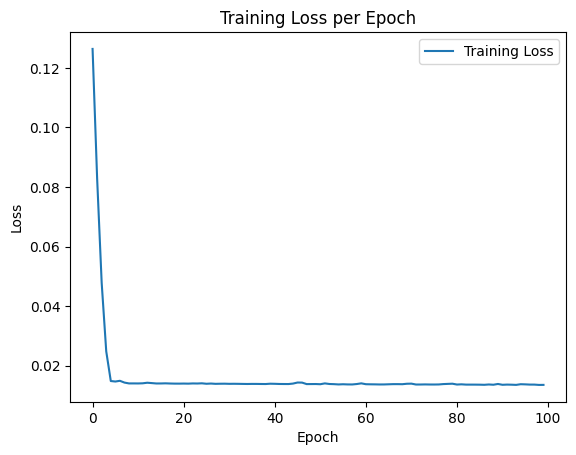

In [70]:
# Extract loss from the training history
loss_per_epoch = history.history['loss']

# Plot the training loss
import matplotlib.pyplot as plt

plt.plot(range(len(loss_per_epoch)), loss_per_epoch, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()


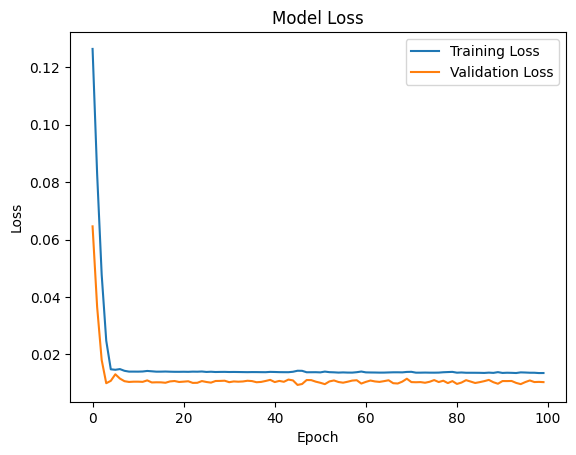

In [71]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [72]:
test_loss = model.evaluate(testX, testY, verbose=0)
print(f"Test Loss: {test_loss}")


Test Loss: 0.010343218222260475


In [73]:
# Generate predictions
train_predictions = model.predict(trainX)
test_predictions = model.predict(testX)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [74]:
# Invert predictions
train_predictions = scaler.inverse_transform(train_predictions)
trainY_original = scaler.inverse_transform(trainY.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
testY_original = scaler.inverse_transform(testY.reshape(-1, 1))

# Debugging shapes
print(f"train_predictions: {train_predictions.shape}, trainY_original: {trainY_original.shape}")
print(f"test_predictions: {test_predictions.shape}, testY_original: {testY_original.shape}")

train_predictions: (131, 1), trainY_original: (131, 1)
test_predictions: (31, 1), testY_original: (31, 1)


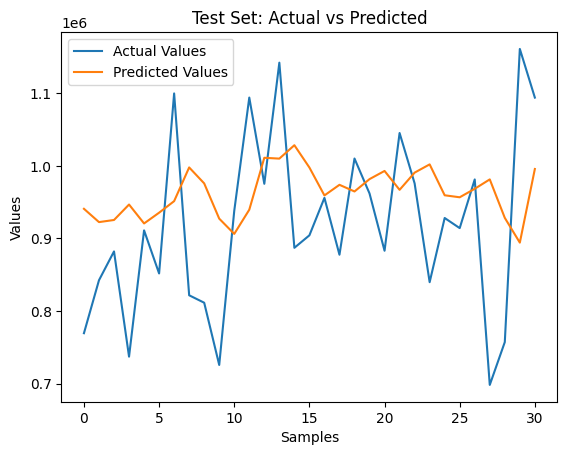

In [75]:
# Plot test predictions vs actual values
plt.plot(testY_original, label='Actual Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()


In [76]:
# Calculate RMSE
train_score = math.sqrt(mean_squared_error(trainY_original, train_predictions))
print('Train Score: %.2f RMSE' % train_score)

test_score = math.sqrt(mean_squared_error(testY_original, test_predictions))
print('Test Score: %.2f RMSE' % test_score)


Train Score: 149431.58 RMSE
Test Score: 130919.67 RMSE


In [77]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
train_mape = mean_absolute_percentage_error(trainY_original, train_predictions)
test_mape = mean_absolute_percentage_error(testY_original, test_predictions)

print('Train Score: %.2f MAPE' % train_mape)
print('Test Score: %.2f MAPE' % test_mape)

Train Score: 11.29 MAPE
Test Score: 12.29 MAPE


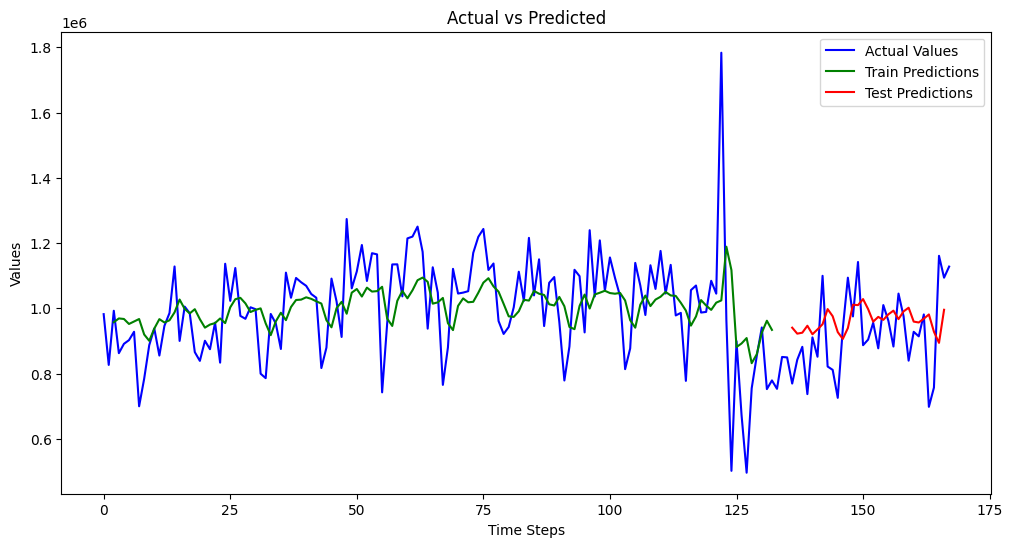

In [78]:
# Reshape predictions to 3D to match data2 shape
train_predictions = train_predictions.reshape(-1, 1, 1)
test_predictions = test_predictions.reshape(-1, 1, 1)

# Initialize empty arrays for plotting
train_predictions_plot = np.empty_like(data2)
train_predictions_plot[:, :, :] = np.nan
train_predictions_plot[look_back:len(train_predictions) + look_back, :, :] = train_predictions

test_predictions_plot = np.empty_like(data2)
test_predictions_plot[:, :, :] = np.nan
test_predictions_plot[len(train_predictions) + (look_back * 2) + 1:len(data2) - 1, :, :] = test_predictions

# Plot predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data2[:, :, 0]), label='Actual Values', color='blue')
plt.plot(train_predictions_plot[:, :, 0], label='Train Predictions', color='green')
plt.plot(test_predictions_plot[:, :, 0], label='Test Predictions', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()


In [79]:
# Generate test predictions and flatten
test_predictions = model.predict(testX).flatten()

# testY is flattened to 1D for compatibility
testY = testY.flatten()

# Ensure the lengths of predictions and actual values match
assert len(test_predictions) == len(testY), "Mismatch between predictions and actuals"

# Create a DataFrame for comparison
test_results = pd.DataFrame({
    'Test Predictions': test_predictions,
    'Actuals': testY
})
print(test_results.head(5))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
   Test Predictions  Actuals
0              0.35     0.21
1              0.33     0.27
2              0.33     0.30
3              0.35     0.19
4              0.33     0.32


In [81]:
# Reshape to 2D for inverse transformation
testY = testY.reshape(-1, 1)
test_predictions = test_predictions.reshape(-1, 1)

# Inverse transform to original scale
testY_original = scaler.inverse_transform(testY).flatten()
test_predictions_original = scaler.inverse_transform(test_predictions).flatten()

# Debugging output
print(f"First 5 Original Test Values: {testY_original[:5]}")
print(f"First 5 Original Predictions: {test_predictions_original[:5]}")


First 5 Original Test Values: [769547. 842475. 882186. 737259. 911174.]
First 5 Original Predictions: [940895.44 922571.94 925495.6  946779.56 920719.5 ]


In [83]:
# Create DataFrame with results
# Ensure proper display of floating-point numbers
pd.options.display.float_format = '{:,.2f}'.format
test_results = pd.DataFrame(data={
    'Test Predictions': test_predictions_original,
    'Actuals': testY_original
})

print(test_results.tail(10))

    Test Predictions      Actuals
21        967,030.06 1,045,309.00
22        990,726.88   975,943.06
23      1,002,068.69   839,803.00
24        959,512.56   928,231.00
25        956,764.25   914,288.00
26        968,470.12   981,360.00
27        981,398.81   698,304.00
28        928,406.62   757,297.00
29        894,298.00 1,161,116.00
30        995,734.50 1,094,073.00


In [84]:
# New column for Test Predictions
data1['Test Predictions'] = np.nan

# Define start and end indices for test predictions
start_index = train_set + look_back
end_index = start_index + len(test_predictions_original)

# Check the range being assigned
print(f"Assigning predictions to rows {start_index} to {end_index - 1}")

# Assign test predictions to the specified range
data1.iloc[start_index:end_index, data1.columns.get_loc('Test Predictions')] = test_predictions_original

print(data1.tail())

Assigning predictions to rows 136 to 166
      Volume  Test Predictions
163   698304        981,398.81
164   757297        928,406.62
165  1161116        894,298.00
166  1094073        995,734.50
167  1128120               NaN


In [85]:
# Manually predict the last row
last_input = data2[-look_back:, :].reshape(1, look_back, 1)  # Input sequence for the last row
last_prediction = model.predict(last_input).flatten()  # Predict the last value
last_prediction_original = scaler.inverse_transform(last_prediction.reshape(-1, 1)).flatten()[0]

# Assign the prediction to the last row
data1.loc[167, 'Test Predictions'] = last_prediction_original

print(data1.tail(12))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
      Volume  Test Predictions
156   883101        993,037.88
157  1045309        967,030.06
158   975943        990,726.88
159   839803      1,002,068.69
160   928231        959,512.56
161   914288        956,764.25
162   981360        968,470.12
163   698304        981,398.81
164   757297        928,406.62
165  1161116        894,298.00
166  1094073        995,734.50
167  1128120      1,045,124.31
